## Timeline
**Start of Project:** 04.11.2019 
**Submission of Project Results:** 27.11.2019

**Phases:** 
1. Week (06.11 - 12.11): Preprocessing 
2. Week (13.11 - 19.11): Iterate & Evaluate the Models 
3. Week (20.11 - 26.11): Writing the Report

## Responsibilities
- Liste mit Begründungen für Auswahl der Feature (Feature | Begründung) - Jannik
- Preprocessing: 
  - Neighbourhood_cleansed (One-hot) (& PLZ Gibt es genug Beispiele prüfen?)- Daniel 
  - Property_type (One-hot) - Jannik 
  - Room_type (One-hot) - Jannik
  - Accomodates - Caro
  - Bathrooms (Maybe) - Caro
  - Bedrooms - Fritz
  - Amenities - Jakob
  - Beds - Fritz
  - Bed_type (One-hot) - Fritz

- Juli Datensatz fürs Preprocessing

# Airbnb Price Prediction

## Goal
The goal of our data mining project is to predict prices for new Airbnb listings in Munich. To achieve this, we will train a regression model on existing Airbnb data from www.insideairbnb.com.

## Import libraries

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from math import sqrt
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest, SelectFwe
from collections import Counter
import seaborn as sns
import numpy as np
import geopandas as gpd #requires install via conda/pip
import geoplot as glt #requires install via conda/pip
from shapely.geometry import Point, polygon



## Load the data

In [103]:
munich = pd.read_csv('Data/listings_Munich_July.csv')

# drop all colums except the ones that we are using
munich = munich.loc[:, munich.columns.intersection(['neighbourhood_cleansed', 'property_type', 
                                                    'room_type', 'accommodates', 'bathrooms', 'bedrooms',
                                                    'beds', 'bed_type', 'price', 'amenities', 
                                                    'extra_people','guests_included', 'longitude', 'latitude'])]

## Understand & Preprocess the data

In [104]:
#munich.head()

In [105]:
# understand feature neighbourhoods_cleansed
print(munich['neighbourhood_cleansed'].value_counts())

Ludwigsvorstadt-Isarvorstadt                              1077
Maxvorstadt                                               1000
Schwabing-West                                             735
Neuhausen-Nymphenburg                                      702
Au-Haidhausen                                              686
Schwabing-Freimann                                         589
Bogenhausen                                                471
Milbertshofen-Am Hart                                      428
Sendling                                                   427
Schwanthalerhöhe                                           409
Ramersdorf-Perlach                                         368
Sendling-Westpark                                          361
Thalkirchen-Obersendling-Forstenried-Fürstenried-Solln     359
Laim                                                       353
Obergiesing                                                346
Untergiesing-Harlaching                                

### Price

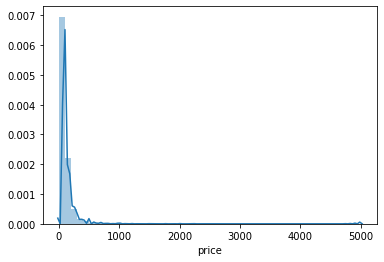

Listings that qualify as outliers (using Standard Deviation):
167


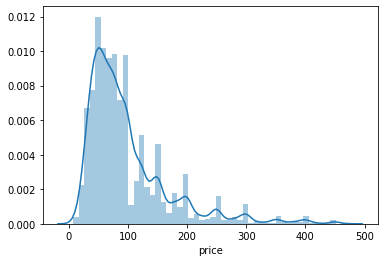

count    10071.000000
mean       119.716215
std         99.014600
min          8.000000
25%         60.000000
50%         90.000000
75%        149.000000
max       2753.000000
Name: max_price, dtype: float64

count    10071.000000
mean        98.496177
std         69.968492
min          8.000000
25%         50.000000
50%         79.000000
75%        120.000000
max        470.000000
Name: price, dtype: float64


In [106]:
# convert column price and extra people to float values without leading $ sign
munich['price'] = munich['price'].replace( '[\$,)]','', regex=True ).astype(float)
munich['extra_people'] = munich['extra_people'].replace( '[\$,)]','', regex=True ).astype(float)

#examine distribution
sns.distplot(munich['price'])
plt.show()

#outlier detection
price_std = np.std(munich['price'])
price_mean = np.mean(munich['price'])
print("Listings that qualify as outliers (using Standard Deviation):")
print(munich[munich['price'] > (price_mean + (3*price_std))]['price'].count())
munich = munich[munich['price'] <= (price_mean + (3*price_std))]

#examine distribution again
sns.distplot(munich['price'])
plt.show()

#create variable accounting for maximium price of each listing
for i, row in munich.iterrows():
    if row.guests_included < row.accommodates:
        munich.loc[i, 'max_price'] = row.price + (row.accommodates - row.guests_included) * row.extra_people
    else:
        munich.loc[i, 'max_price'] = row.price
            
print(munich['max_price'].describe())
print()
print(munich['price'].describe())   

munich = munich.drop(columns = ['guests_included', 'extra_people'])                                     

#scaler = preprocessing.StandardScaler()
#munich[['price', 'max_price']] = scaler.fit_transform(munich[['price', 'max_price']])


The prices of 167 listings are more than 3 Standard Deviations above the mean. Therefore, these data points are excluded. Afterwards, the distribution more closely resembles a normal distribution. 

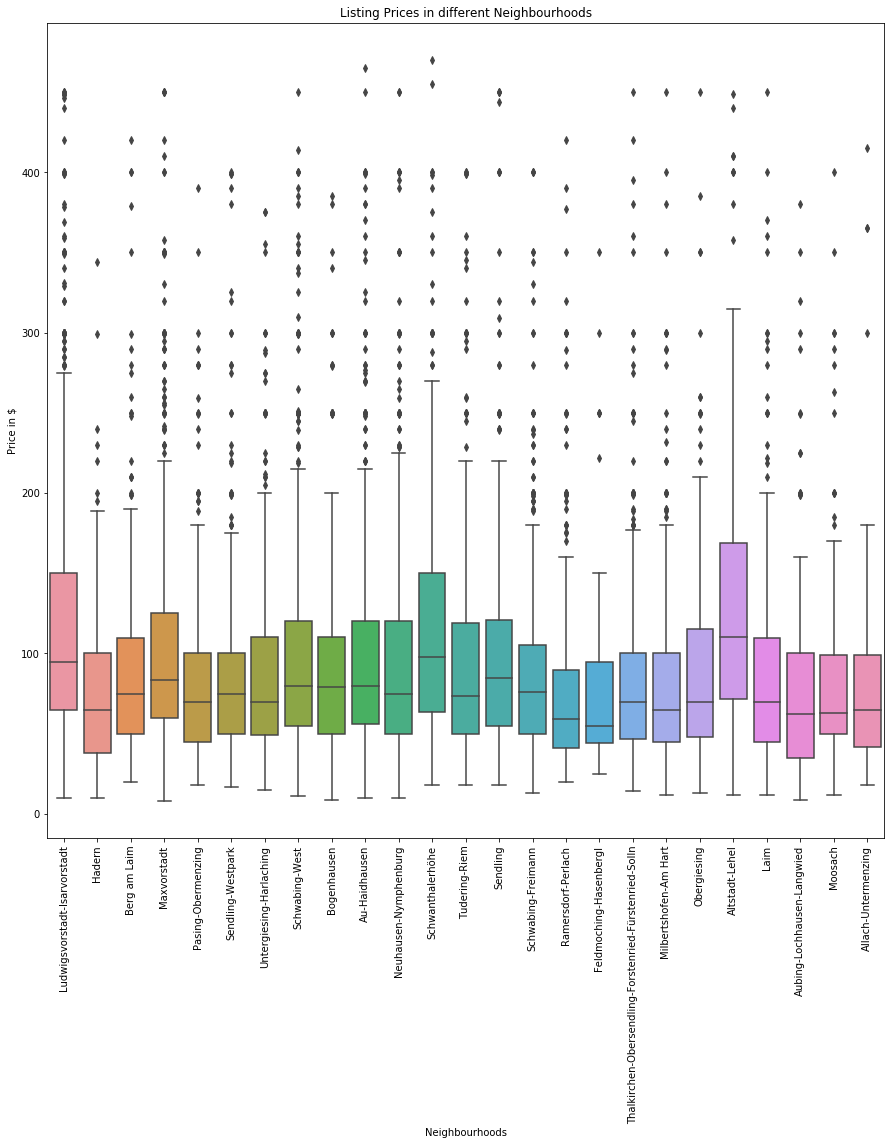

In [107]:
#Visualizing

fig,ax = plt.subplots(figsize = (15, 15), )
sns.boxplot(x = munich['neighbourhood_cleansed'], y = munich['price'], ax=ax)
plt.xticks(rotation=90)
plt.xlabel('Neighbourhoods')
plt.ylabel('Price in $')
plt.title('Listing Prices in different Neighbourhoods')
plt.show()

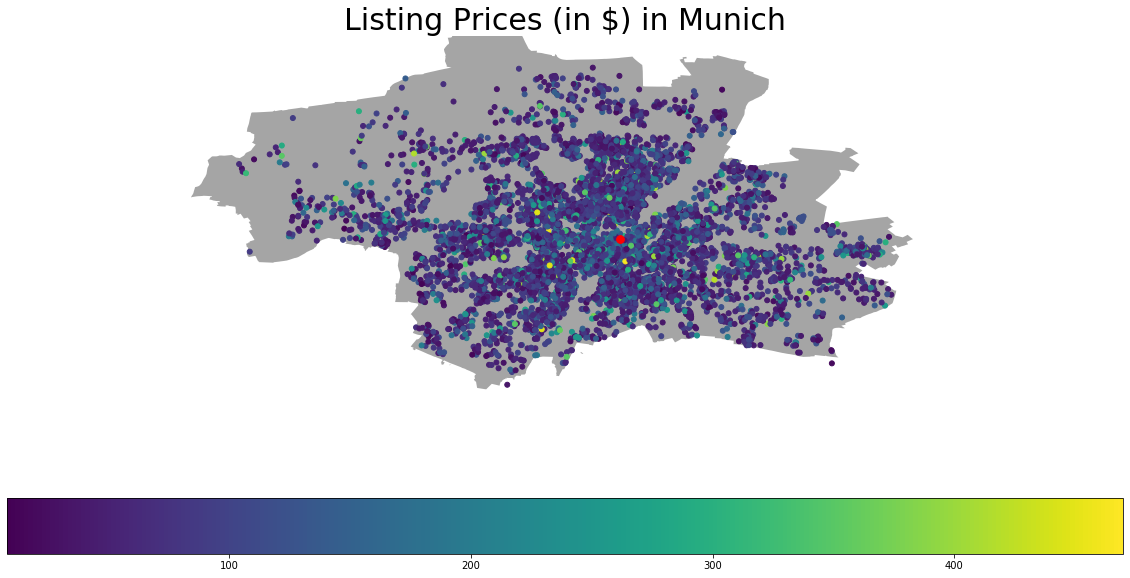

In [108]:
#read shapefile of Bavaria
munich_sh = 'Data//Geodata/gmd_ex.shp'
map_df = gpd.read_file(munich_sh)

#keep only data of Munich
#map_df = (map_df['BEZ_GEM'] == 'MÃ¼nchen')

#Create point for every listing
geometry = [Point(xy) for xy in zip (munich['longitude'], munich['latitude'])]
munich = munich.drop(columns = ['longitude', 'latitude'])
crs = {'init': 'epsg:4326'} # crs-data tells geopandas how the data relate to points in the real worlds (e.g. latitude and longitude)
map_df = map_df.to_crs(epsg=4326) #convert given shapefile to latitude and longitude-crs

point_marienplatz = gpd.GeoSeries(Point(11.576006, 48.137079),crs=crs)

#create Geo-DataFrame with Points and Prices for each listing
geo_df = gpd.GeoDataFrame(munich['price'], crs = crs, geometry = geometry)

#compute distance to Marienplatz as a proxy for the city centre
geo_df['distance_centre'] = geo_df.distance(Point(11.576006, 48.137079))
geo_df['distance_centre'].describe()

#add feature to DataFrame and create a Geopandas-object for plotting
munich['distance_centre'] = geo_df['distance_centre']
point_marienplatz = gpd.GeoSeries(Point(11.576006, 48.137079),crs=crs)

#plot the data
ax = map_df[(map_df['BEZ_GEM'] == 'MÃ¼nchen')].plot(figsize=(20, 10), alpha=0.7, color = 'grey')
plt.title('Listing Prices (in $) in Munich', fontsize=30)
glt.pointplot(geo_df, ax=ax, hue=munich['price'], legend=True, legend_kwargs={'orientation': 'horizontal'})
#glt.pointplot(geo_df, ax=ax, hue=munich['distance_centre'], legend=True, legend_kwargs={'orientation': 'horizontal'})
point_marienplatz.plot(ax=ax, markersize= 60,  color = 'red') #plot location of the Marienplatz

AxesSubplot(0.125,0.125;0.775x0.755)


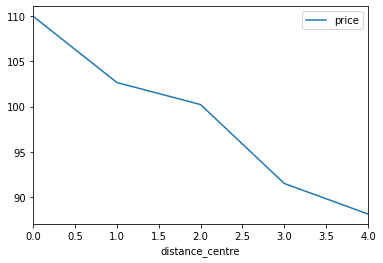

In [109]:
#discretise distance_centre
discretiser = preprocessing.KBinsDiscretizer(n_bins=5, encode='ordinal')
munich['distance_centre'] = discretiser.fit_transform(munich['distance_centre'].values.reshape(-1, 1))

#plot relationship between price and distance to city centre
distance_price = munich[['distance_centre', 'price']].groupby('distance_centre').mean()
print(distance_price.plot())

These visuals suggest that there is not only a significant difference in the median prices in the different neighbourhoods of Munich, but also that more expensive listings appear to be clustered in and around the centre of the city. 

The further away a listing is from the centre of the city (Marienplatz), the less expensive it is on average. This describtive analysis warrants further examination using inference methods. 

### Bedrooms

0.0     1018
1.0     7621
2.0     1106
3.0      249
4.0       50
5.0        3
7.0        1
8.0        6
10.0       1
20.0       1
25.0       1
Name: bedrooms, dtype: int64
               price
bedrooms            
0.0        90.322200
1.0        89.239076
2.0       146.810127
3.0       172.337349
4.0       236.560000
AxesSubplot(0.125,0.125;0.775x0.755)


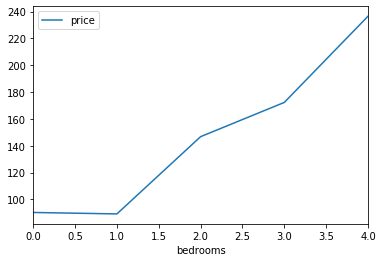

In [110]:
# Fritz: understand feature bedrooms 
# check the value count
print(munich['bedrooms'].value_counts().sort_index())

# drop listings with more than 4 bedrooms
munich = munich[munich.bedrooms < 5]

# analyze the effect of bedroom number on price
bedrooms_price = munich[['bedrooms', 'price']].groupby('bedrooms').mean()

# print the mean values for number of bedrooms
print(bedrooms_price)

# print the plot
print(bedrooms_price.plot())

# replace zero bedrooms with one bedroom
munich.loc[munich.bedrooms == 0.0, 'bedrooms'] = 1.0

One can see that most listings have one or two bedrooms. In 1023 cases there seems to be no bedroom. This value is set by Airbnb landlords if there is not seperated bedroom (e.g. a one room apartment or when accommodating in the living room). It needs to be evaluated how well several regression models can handle this encoding.

The listings with 25, 20 and 10 bedrooms are hostels. As there only exist 16 listings with more than four bedrooms, it might make sense to drop those as these are extreme outliers. We can later on specify that our model is only able to predict price for new listings with less than five bedrooms.

There is a clear linear dependency between number of bedrooms and price if one only looks at listings with one to four bedrooms. The difference in prices between zero and one bedroom is almost not present. Thus, it makes sense to combine those listings. Every listing with zero bedrooms will be changed to one bedroom. This also needs to be applied when inferring later on.

### Beds

0.0       48
1.0     6547
2.0     2422
3.0      541
4.0      260
5.0       85
6.0       70
7.0       24
8.0       28
9.0        1
10.0       2
14.0       1
16.0       5
Name: beds, dtype: int64
           price
beds            
1.0    83.783565
2.0   114.466557
3.0   145.225508
4.0   157.084615
5.0   166.517647
6.0   206.100000
7.0   191.541667
8.0   138.857143
AxesSubplot(0.125,0.125;0.775x0.755)


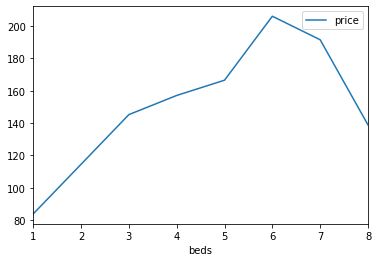

In [111]:
# Fritz: understand feature beds
# check the value count
print(munich['beds'].value_counts().sort_index())

# drop listings with more than 8 beds
munich = munich[munich.beds < 9]

# drop listings with less than 1 beds
munich = munich[munich.beds > 0]

# analyze the effect of number of beds on price
beds_price = munich[['beds', 'price']].groupby('beds').mean()

# print the mean values for number of beds
print(beds_price)

# print the plot
print(beds_price.plot())

# also drop listings with more than 6 beds
munich = munich[munich.beds < 7]

Here one can see a similar situation as with the number of bedrooms. Most listings have one or two beds. In 48 cases Airbnb landlords set the number of beds to zero. A manual check of some listings showed that beds are actually present and listings were not created correctly. Thus, listings with zero beds will not be considered in the training.

Only 10 listings offer 9 or more beds. These might be dropped as well like examples with five ore more bedrooms.

There is a close to linear dependecy between the number of beds and the price if one only looks at examples with less than six beds. The price seems to decrease if there are more than six beds. It might make sense to also drop listings with seven or eight beds.

### Bed_type

Real Bed         9423
Pull-out Sofa     336
Couch              78
Futon              61
Airbed             27
Name: bed_type, dtype: int64
                   price
bed_type                
Airbed         94.851852
Couch          78.551282
Futon          78.885246
Pull-out Sofa  78.258929
Real Bed       99.115356
AxesSubplot(0.125,0.125;0.775x0.755)


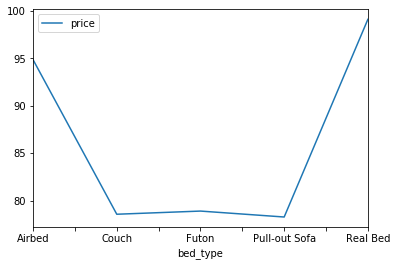

In [112]:
# Fritz: understand feature bed_type
# check the value count
print(munich['bed_type'].value_counts())

# analyze the effect of bed_type on price
bed_type_price = munich[['bed_type', 'price']].groupby('bed_type').mean()

# print the mean values for bed_types
print(bed_type_price)

# print the plot
print(bed_type_price.plot())

# ordinal encoding
# create replace map
replace_map = {'bed_type': {'Couch': 1, 'Futon': 1, 'Pull-out Sofa': 1, 'Airbed': 2, 'Real Bed': 3}}

# replace categorical values using replace map
munich = munich.replace(replace_map)

One can see that real beds are offered in the great majority (95%) of all listings. Pull-out sofas occur in about 3% while listings with bed types couch, futon and airbed are not really present in the dataset.

It is interesting to see that prices of listings with airbeds are significantly higher compared to couch, futon or pull-out sofa. The prices for real bed listings are the highest which is not surprising. With respect to the dependencies, it makes sense to do an ordnial encoding of this categorical feature. Couch, futon and pull-out-sofa will be converted to value 1, airbed to value 2 and real bed to value 3.

### Amenities

As they potentially provide significant value to the customers of Airbnb (e.g. kitchen, internet), amenities could easily affect the price of a given listing and are therefore included in the analysis.

First, as the amenities in the data are given as a list of strings per listing, we have to split the data in order to analyse which specific amenities might be useful to the analysis.

In [113]:
all_amenities = list()  #create list of all individual amenities
for amenities in munich['amenities']:
    for amenity in amenities.split("{")[1].split("}")[0].split(","):
        all_amenities.append(amenity.replace('"', ''))
#all_amenities_set = set(all_amenities)
Counter(all_amenities).most_common(50)

[('Heating', 9422),
 ('Wifi', 9288),
 ('Kitchen', 9035),
 ('Essentials', 9029),
 ('Washer', 7663),
 ('Smoke detector', 6894),
 ('Hair dryer', 6738),
 ('Hangers', 6515),
 ('Laptop friendly workspace', 6203),
 ('TV', 6092),
 ('Iron', 5780),
 ('Shampoo', 5415),
 ('Hot water', 4478),
 ('Elevator', 4341),
 ('Dryer', 3393),
 ('Lock on bedroom door', 3341),
 ('Refrigerator', 2867),
 ('Internet', 2837),
 ('Dishes and silverware', 2792),
 ('Host greets you', 2695),
 ('Bed linens', 2659),
 ('Stove', 2638),
 ('Cooking basics', 2620),
 ('Family/kid friendly', 2411),
 ('Cable TV', 2393),
 ('Oven', 2271),
 ('Buzzer/wireless intercom', 2170),
 ('First aid kit', 2113),
 ('Coffee maker', 2043),
 ('Dishwasher', 1903),
 ('Free parking on premises', 1856),
 ('Free street parking', 1797),
 ('Patio or balcony', 1642),
 ('Private entrance', 1582),
 ('Fire extinguisher', 1517),
 ('No stairs or steps to enter', 1473),
 ('Carbon monoxide detector', 1446),
 ('translation missing: en.hosting_amenity_50', 1409),
 

We now can filter out those amenities which conceivably affect the price and which are occuring often enough in order to be regarded as significant.

We extract these features into a list and create new variables for each one to perfom One-Hot-Encoding.

In [114]:
relevant_amenities = ['Wifi', 'Internet', 'TV', 'Kitchen', 'Heating', 'Washer', 'Patio or balcony', 
                      'Breakfast', 'Elevator','24-hour check-in', 'Pool', 
                      'Private entrance','Dishwasher', 'Bed linens','Smoking allowed'] 

for element in relevant_amenities: #create dummy variables
    munich[element.lower()] = 0
    
for row in munich.itertuples(): #can take a moment
    for element in relevant_amenities:
        if element in row.amenities:
            munich.loc[row.Index, element.lower()] = 1
            
munich = munich.drop(columns = 'amenities')

In [115]:
for amenity in relevant_amenities: #analyse features with regard to districts
    print(pd.crosstab(munich['neighbourhood_cleansed'], munich[amenity.lower()]))
    print() 

wifi                                                 0    1
neighbourhood_cleansed                                     
Allach-Untermenzing                                  1   58
Altstadt-Lehel                                      18  297
Au-Haidhausen                                       35  622
Aubing-Lochhausen-Langwied                           4   77
Berg am Laim                                        17  191
Bogenhausen                                         34  428
Feldmoching-Hasenbergl                               3   91
Hadern                                               7  113
Laim                                                26  312
Ludwigsvorstadt-Isarvorstadt                        67  949
Maxvorstadt                                         59  919
Milbertshofen-Am Hart                               33  390
Moosach                                             10  179
Neuhausen-Nymphenburg                               46  644
Obergiesing                             

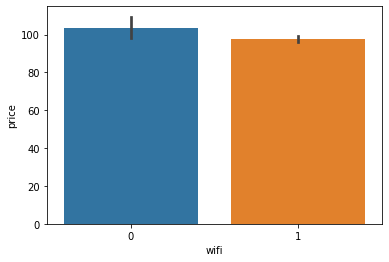

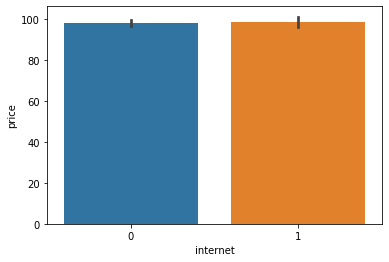

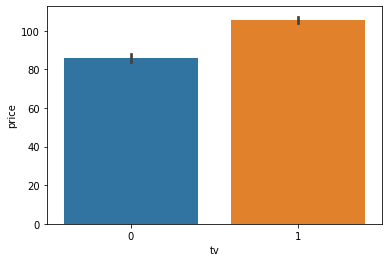

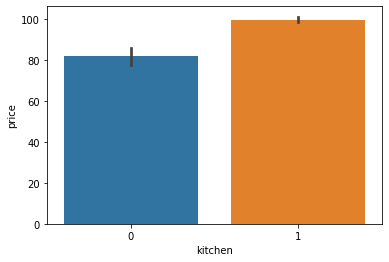

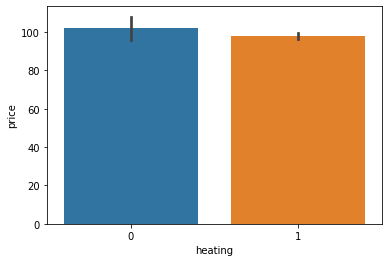

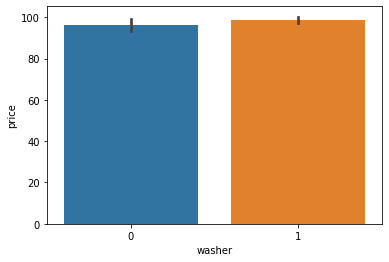

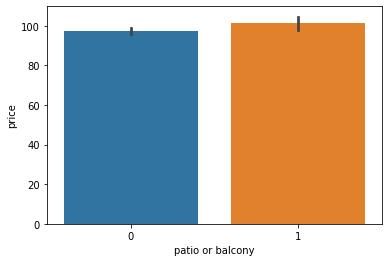

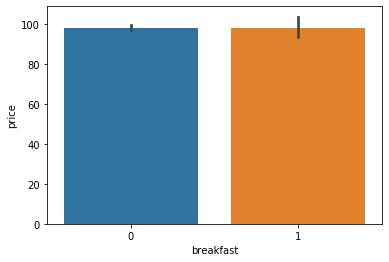

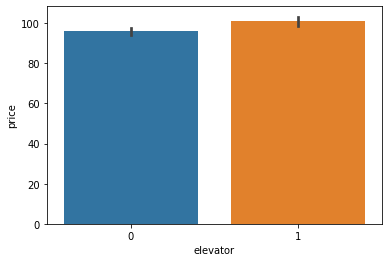

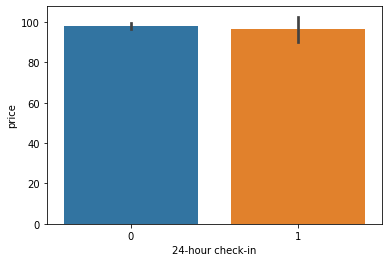

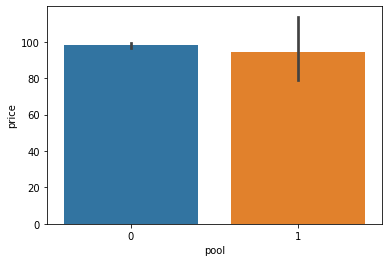

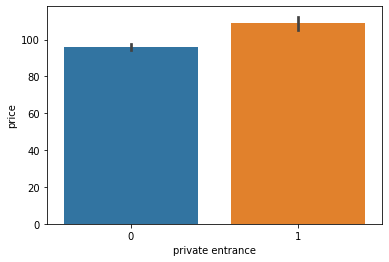

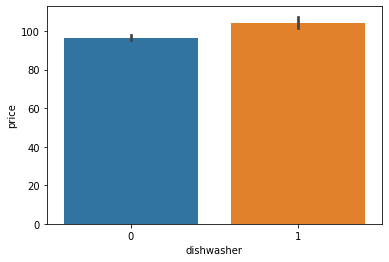

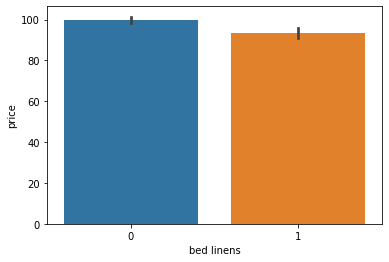

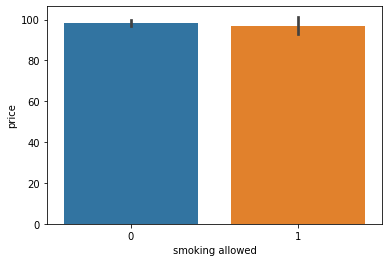

In [116]:
#Visualize
for amenity in relevant_amenities: #analyse features with regard to districts
    sns.barplot(x= munich[amenity.lower()], y='price', data=munich)
    plt.show()

In [117]:
#merge information from variables wifi and internet in the feature 'internet'
for row in munich.itertuples():
        if row.wifi == 1:
            munich.loc[row.Index, 'internet'] = 1

munich = munich.drop(columns = ['wifi', 'pool', 'bed linens'])
munich['internet'].describe()

count    9925.000000
mean        0.941965
std         0.233822
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: internet, dtype: float64

The features 'internet' and 'wifi' appear to be redundant. Therefore, the latter can be discarded. Furthermore, there seems to be a relatively small number of 'pools' in the data which suggests that the variable should be filtered out as well. Apart from that, it appears very likely that the infrequent occurence of the feature 'bed linens' is due to hosts not giving the respective information correctly. Thus, the feature is excluded accordingly.


The visualizations of the respective amenities versus the prices of listings indicate a positive effect of the features kitchen, tv and private entrance, among others. However, these indications require verification during the actual modeling process.


### Bathrooms

The number of bathrooms, since it is considered a comfort zone for the customer, is regarded another important feature for the analysis. Here Airbnb not only differentiates the number of bathrooms, but also whether it is a shared or private bathroom, as Airbnb also allows the property to be shared with other Airbnb customers and the host. So it is possible that hosts can charge a higher price for private bathrooms, as this also increases the usable space of a guest.

In [118]:
# Drop all tuples with blank entries
munich = munich[munich.bathrooms != None]

# Drop all tuples with more than 2.5 bathrooms as they are suspected outliers
munich = munich[munich.bathrooms < 3.0]

# replace zero bathrooms with shared bathroom
munich.loc[munich.bathrooms == 0.0, 'bathrooms'] = 0.5

Columns in which no input was made are removed directly from the data set because they do not provide useful information for analysis. The value "0.5" refers to a shared bathroom, while the values "1.5" and "2.5" refer to an additional guest toilet without shower. Since apartment types such as "tent" or "campervan" have already been deleted and prices are only to be predicted for real houses, it can be assumed that there is always a bathroom for guests and the host has made a wrong entry or merely indicated not to offer a bathtub. Therefore, all entries with the value "0.0" can be raised to "0.5". Even apartments with more than "3.0" bathrooms will be removed, as they are considered outliers and an apartment with more than 3 bathrooms is available in too few neighborhoods to accurately predict prices.

1.0    8540
1.5     812
2.0     381
0.5     111
2.5      52
Name: bathrooms, dtype: int64
                price
bathrooms            
0.5         75.783784
1.0         95.750351
1.5        105.769704
2.0        134.887139
2.5        142.980769


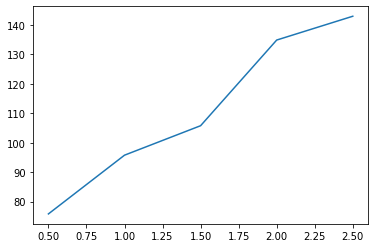

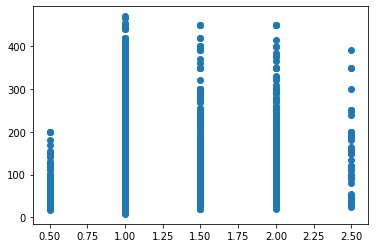

In [119]:
# check the value count
print(munich['bathrooms'].value_counts())

# analyze the effect of bathrooms on price
bathroom_price = munich[['bathrooms', 'price']].groupby('bathrooms').mean()

# print the mean values for bathrooms
print(bathroom_price)

# plot the effect of bathrooms on price
plt.plot(bathroom_price)

# print the plot
plt.show()

#Create a scatterplot of Price on Bathrooms
plt.scatter(munich['bathrooms'], munich['price'])

plt.show()

In considering the number of bathrooms in the offers as well as the ratio between the number of bathrooms and the price of the real estate, there are some things that attract attention. Firstly, most of the apartments offered on Airbnb have their own bathroom for the guests. Only with greater distance follow other types of apartments. Secondly, the effect of the number of bathrooms on the house price is almost linear, with the exception that the price increase between apartments with "1.0" and "1.5" bathrooms is lower than between "1.5" and "2.0" bathrooms.

### Accommodates

Another feature to be included in the analysis is the number of people who can be accommodated in the home. Since the number of square metres is not included in the analysis because too few entries are offered for a prediction, both the number of accommodations and the number of beds can be used to estimate the size of the accommodation. However, the accommodations that allow more than 10 possible guests are deleted because there are too few entries for an accurate prediction.

2     5254
4     1571
3     1229
1     1212
5      254
6      246
8       65
7       38
10      11
9        6
13       3
12       3
11       2
16       2
Name: accommodates, dtype: int64
                   price
accommodates            
1              58.968647
2              85.135325
3             107.018714
4             134.671547
5             160.968504
6             177.731707
7             181.236842
8             192.430769
9             202.500000
10            186.272727


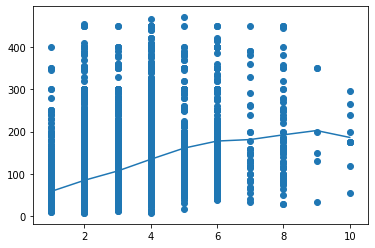

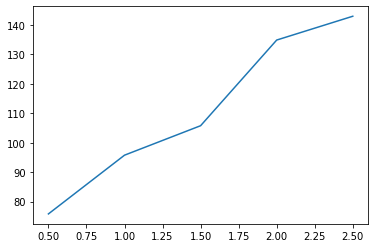

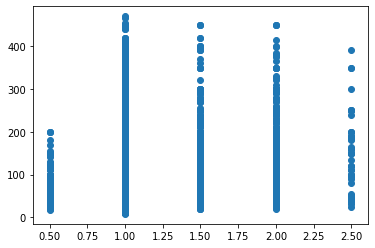

In [120]:
# check the value count
print(munich['accommodates'].value_counts())

# Drop all tuples with more than 10 accommodates as they are suspected outliers
munich = munich[munich.accommodates <= 10]

# analyze the effect of accommodates on price
accommodates_price = munich[['accommodates', 'price']].groupby('accommodates').mean()

# print the mean values for accommodates
print(accommodates_price)

# print the plot
plt.plot(accommodates_price)

#Create a scatterplot of Price on Accommodates
plt.scatter(munich['accommodates'], munich['price'])

plt.show()





# plot the effect of bathrooms on price
plt.plot(bathroom_price)

# print the plot
plt.show()

#Create a scatterplot of Price on Bathrooms
plt.scatter(munich['bathrooms'], munich['price'])

plt.show()












# Normalize the bathroom and accommodates featurewith values from 0 to 1
# create the normaliser
scaler = preprocessing.MinMaxScaler()

# Preprocess the features Bathrooms and Accommodates
munich[['bathrooms', 'accommodates']] = scaler.fit_transform(munich[['bathrooms', 'accommodates']])



In [121]:
# one-hot encoding where necessary

## Compare different months

In [122]:
munich_09 = pd.read_csv('Data/listings_19_09.csv')
munich_09['price'] = munich_09['price'].replace( '[\$,)]','', regex=True ).astype(float)
munich_08 = pd.read_csv('Data/listings_19_08.csv')
munich_06 = pd.read_csv('Data/listings_19_06.csv')
munich_05 = pd.read_csv('Data/listings_19_05.csv')

C:\Users\jakob\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (43,61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [123]:
print('May')
print('Median: ', munich_05['price'].median())
print('Mean: ', munich_05['price'].mean())
print()
print('June')
print('Median: ', munich_06['price'].median())
print('Mean: ', munich_06['price'].mean())
print()
print('July')
print('Median: ', munich['price'].median())
print('Mean: ', munich['price'].mean())
print()
print('August')
print('Median: ', munich_08['price'].median())
print('Mean: ', munich_08['price'].mean())
print()
print('September')
print('Median: ', munich_09['price'].median())
print('Mean: ', munich_09['price'].mean())


May
Median:  80.0
Mean:  107.91782208278514

June
Median:  80.0
Mean:  108.27851247887044

July
Median:  79.0
Mean:  98.03085170948816

August
Median:  80.0
Mean:  113.40779101741522

September
Median:  89.0
Mean:  119.22780610180465


One can see that the average prices are quite stabile from May to August but increase a lot in September. This can be traced back to the Oktoberfest in Munich that takes place in September. We need to find a good solution for dealing with these variations. 